# Recommender system exploration

## Trial development of a recommender system for an online cinema based on [Rekko-challenge](https://boosters.pro/championship/rekko_challenge/overview) competition data

## Content
* [Dataset](#Dataset)
* [Model development](#Model-development)
* [Training](#Training)
* [Inference](#Inference)
* [Evaluation](#Evaluation)
* [Operating time](#Operating-time)
* [Criticism](#Criticism)
* [Summary](#Summary)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further-development)

In [13]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp

from pprint import pprint

In [14]:
from datetime import timedelta
from IPython.display import Image
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import swifter

sns.set_style('whitegrid')

In [68]:
from IPython.display import Image

In [15]:
import matplotlib
matplotlib.rc('figure', figsize=(10, 5))

In [16]:
DATA_PATH = '..\\data'

## Dataset

The dataset includes:<br>
- catalog of movies and TV series
- users' transactions
- custom movie ratings
- table with information about items added by users to the bookmarks list

Based on analysis performed in a separate jupyter-notebook:<br>

- The data set contains information for 30 days (transactions, rating, and bookmarks)
- The catalog contains data about 10200 items
- There are 8447928 entries in the transaction log

t_begin - time when the service started <br>
t_first - time of the first action in the dataset <br>
t_now - the time in which to make a recommendation based on the data between the t_first and t_now <br>

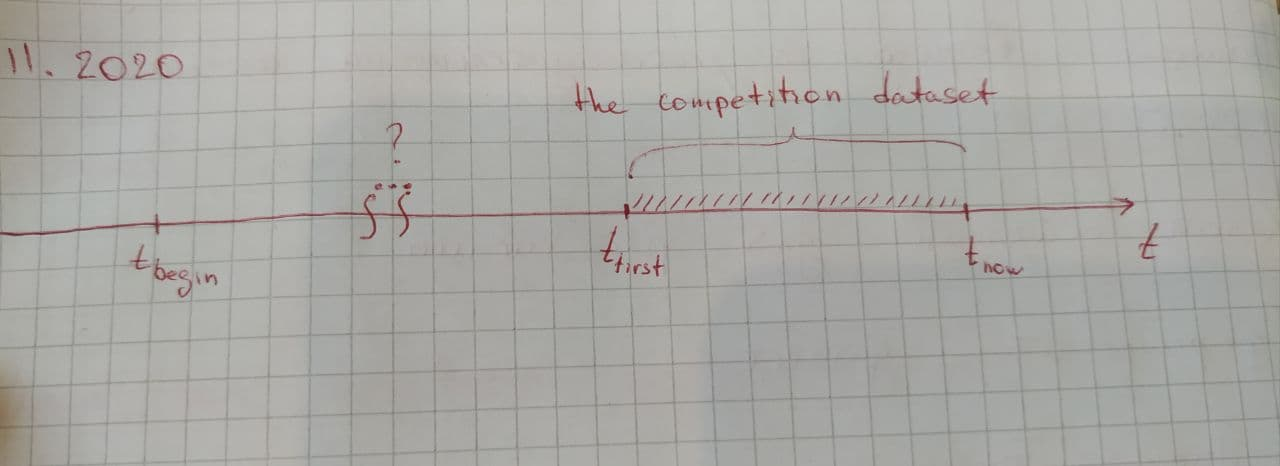

In [69]:
Image(filename='..\\data\\img\\dataset_timelime.jpg')

As a target variable, it needs to predict the 20 films that the user consumed during the test period.
A user is considered to have consumed content if he:
1. Bought it or rented it
2. Watched more than half of the film, if it is available for free or by subscription.
3. Watched more than a third of the series, if it is available for free or by subscription

### Catalogue

In [17]:
with open(os.path.join(DATA_PATH, 'catalogue.json'), 'r') as f:
    catalogue = json.load(f)
    
catalogue = {int(k): v for k, v in catalogue.items()}
catalogue_df = pd.DataFrame.from_dict(catalogue).transpose()
catalogue_df['element_uid'] = catalogue_df.index
catalogue_df.reset_index(drop=True, inplace=True)

In [70]:
catalogue_df.head()

,type,availability,duration,feature_1,feature_2,feature_3,feature_4,feature_5,attributes,element_uid
0,movie,"[purchase, rent, subscription]",140,1.65722e+06,0.75361,39,1.11941,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1983
1,movie,"[purchase, rent, subscription]",110,3.55652e+07,0.766254,41,1.1386,0.654707,"[1, 26, 27, 28, 29, 7, 30, 31, 32, 10, 14, 15,...",3783
2,movie,"[purchase, rent, subscription]",90,1.32707e+07,0.765425,27,1.13181,0.592716,"[1, 38, 39, 40, 7, 41, 42, 43, 14, 15, 17, 18,...",5208
3,movie,"[purchase, rent, subscription]",120,2.17499e+07,0.757874,26,1.13353,0.654707,"[1, 47, 48, 49, 50, 51, 52, 53, 32, 42, 54, 14...",9744
4,movie,"[purchase, rent]",110,9.21296e+06,0.759566,7,1.11013,0.654707,"[1, 59, 60, 61, 62, 7, 52, 63, 10, 42, 54, 17,...",1912


In [71]:
print('The number of unique items in the catalogue = {0}'.format(catalogue_df['element_uid'].nunique()))

The number of unique items in the catalogue = 10200


### Transactions

In [18]:
%%time
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

Wall time: 7.2 s


In [19]:
transactions = transactions.merge(catalogue_df[['type', 'duration', 'element_uid']], how='left', on='element_uid')

In [20]:
transactions = transactions[~transactions['type'].isin(['series', 'multipart_movie'])]
transactions['watched_time_minutes'] = transactions['watched_time'].swifter.apply(lambda x: int(x/60))
transactions['duration'] = transactions['duration'].astype('int32')
transactions['watched_ratio'] = transactions['watched_time_minutes']/transactions['duration']

In [72]:
transactions.head(3)

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer,type,duration,watched_time_minutes,watched_ratio,target
0,3336,5177,S,4.430518e+07,4282,0,50,movie,90,71,0.788889,1
1,481,593316,S,4.430518e+07,2989,0,11,movie,50,49,0.980000,1
2,4128,262355,S,4.430518e+07,833,0,50,movie,100,13,0.130000,0


In [93]:
transactions.shape

(8447928, 12)

The function to label transactions

In [21]:
def set_target(row):
    if row['consumption_mode'] == 'S':
        if row['watched_time_minutes'] < row['duration']*0.5:
            return 0
        else:
            return 1
    else:
        return 1

In [22]:
transactions['target'] = transactions.apply(set_target, axis=1)

### Rating

In [23]:
%%time
ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.uint8
    }
)

Wall time: 260 ms


In [41]:
ratings['user_uid'] = ratings['user_uid'].astype('category')
ratings['element_uid'] = ratings['element_uid'].astype('category')

In [24]:
ratings = ratings.merge(catalogue_df[['type', 'duration', 'element_uid']], how='left', on='element_uid')

In [25]:
ratings = ratings[~ratings['type'].isin(['series', 'multipart_movie'])]

In [73]:
ratings.head()

,user_uid,element_uid,rating,ts,type,duration
0,571252,1364,10,4.430517e+07,movie,130
1,63140,3037,10,4.430514e+07,movie,190
2,443817,4363,8,4.430514e+07,movie,110
3,359870,1364,10,4.430506e+07,movie,130
4,359870,3578,9,4.430506e+07,movie,100


### Train-test split

the first 80% of events go to the training part of the dataset

In [27]:
max_train_ts = transactions['ts'].quantile(0.8)

In [42]:
train_rating = ratings[ratings['ts'] <= max_train_ts]

In [39]:
train_transactions = transactions[transactions['ts'] <= max_train_ts]

In [29]:
test_transactions = transactions[transactions['ts'] > max_train_ts]

### Select test users

In [32]:
test_transactions['user_uid'].nunique()

229764

In [34]:
test_users_candidates = list(set(train_rating['user_uid'].unique()) & set(test_transactions['user_uid'].unique()))

<AxesSubplot:ylabel='Density'>

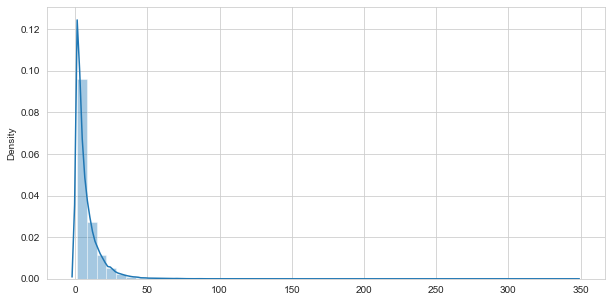

In [35]:
sns.distplot(test_transactions[test_transactions['user_uid'].isin(test_users_candidates)].groupby(['user_uid']).size())

In [36]:
test_transactions[test_transactions['user_uid'].isin(test_users_candidates)].groupby(['user_uid']).size().describe()

count    47302.000000
mean         7.576318
std          9.016917
min          1.000000
25%          2.000000
50%          4.000000
75%         10.000000
max        346.000000
dtype: float64

In [37]:
test_users = test_users_candidates

## Model development

## Select model

As a basic model, we will use item-item based collaborative filtering with a measure of similarity between elements - cosine distance

## Hyperparameters

The hyperparameter for the selected model is the number of movies for which the similarity coefficient will be calculated (or the number of nearest neighbors for each movie)

## Training

In [85]:
train_ratings_matrix = sp.coo_matrix(
    (train_rating['rating'].astype(np.float32) + 1,
        (
            train_rating['element_uid'].cat.codes.copy(),
            train_rating['user_uid'].cat.codes.copy()
        )
    )
)

train_ratings_matrix = train_ratings_matrix.tocsr()

In [94]:
from implicit.nearest_neighbours import CosineRecommender

model = CosineRecommender(K=100)
model.fit(train_ratings_matrix)

In [95]:
train_ratings_matrix_T = train_ratings_matrix.T.tocsr()

In [78]:
user_uid_to_cat = dict(zip(
    train_rating['user_uid'].cat.categories,
    range(len(train_rating['user_uid'].cat.categories))
))

In [79]:
element_uid_to_cat = dict(zip(
    train_rating['element_uid'].cat.categories,
    range(len(train_rating['element_uid'].cat.categories))
))

In [40]:
filtered_elements = train_transactions[train_transactions['user_uid'].isin(test_users)][['user_uid', 'element_uid']].groupby(['user_uid'])['element_uid'].apply(list).to_dict()

In [80]:
filtered_elements_cat = {k: [element_uid_to_cat.get(x, None) for x in v] for k, v in filtered_elements.items()}

## Inference

In [96]:
result = {}

for user_uid in tqdm.tqdm(test_users):
    # transform user_uid to model's internal user category
    try:
        user_cat = user_uid_to_cat[user_uid]
    except LookupError:
        continue
    
    # perform inference
    recs = model.recommend(
        user_cat,
        train_ratings_matrix_T,
        N=10,
        filter_already_liked_items=True,
        filter_items=filtered_elements_cat.get(user_uid, set())
    )
    
    # drop scores and transform model's internal elelemnt category to element_uid for every prediction
    # also convert np.uint64 to int so it could be json serialized later
    result[user_uid] = [int(train_rating['element_uid'].cat.categories[i]) for i, _ in recs]

100%|██████████████████████████████████████████████████████████████████████████| 47302/47302 [00:08<00:00, 5644.57it/s]


## Evaluation

In [82]:
test_users_gt = test_transactions[test_transactions['target'] == 1][['user_uid', 'element_uid']].groupby(['user_uid'])['element_uid'].apply(list).to_dict()

What ratio of recommended movies were viewed by users

In [97]:
metric = 0
ratios = []
for each_user in test_users:
    predicted = result.get(each_user, [])
    gt = test_users_gt.get(each_user, [])
    if len(predicted) == 0:
        intersection_ratio = 0
    else:
        intersection_ratio = len(list(set(predicted) & set(gt)))/len(predicted)
    ratios.append(intersection_ratio)
    metric += intersection_ratio
metric /= len(test_users)

In [98]:
round(metric, 2)

0.02

What ratio of movies viewed were recommendations

In [99]:
metric2 = 0
ratios = []
missed = 0
for each_user in test_users:
    predicted = result.get(each_user, [])
    gt = test_users_gt.get(each_user, [])
    if len(gt) == 0:
        missed += 1
        continue
    else:
        intersection_ratio = len(list(set(predicted) & set(gt)))/len(gt)
    ratios.append(intersection_ratio)
    metric2 += intersection_ratio
metric2 /= (len(test_users) - missed)

In [100]:
round(metric2, 2)

0.04

## Operating time

On the machine with Intel Core i5 6300U 2.40GHz 2.50GHz, 16 Gb RAM <br>
Training process requires 8 sec <br>
Inference for the whole test users set requires 8 sec

## Criticism

This approach (collaborative filtering) allows you to get a forecast only for users who have a history of interactions with the system.

## Summary

The resulting model is a baseline for further development. The main goal when working with data is to study the features of data sets for online cinemas. This model solves the problem by being a starting point for the exploration of recommender systems for content promotion.

## Proposals for the improvement and further development

Apply cold start techniques to build recommendations